In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/github/HEprediction")
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
import monai
from monai.data import  DataLoader, ImageDataset
from monai.transforms import (
    Resize, NormalizeIntensity, Activations, Compose, EnsureType, CenterSpatialCrop,ScaleIntensity,ResizeWithPadOrCrop, ResizeWithPadOrCropd,
    LoadImaged, EnsureChannelFirstd, EnsureTyped, NormalizeIntensityd, ScaleIntensityd,AddChannel
)
from monai.data import CacheDataset, DataLoader, ImageDataset, Dataset
from monai.data import decollate_batch
from monai.networks.nets import DenseNet121
from skimage.morphology import disk, binary_dilation, binary_erosion, remove_small_objects
import pandas as pd
import numpy as np
import nibabel as nib
import torch
import scipy.ndimage as nd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import nibabel.processing
from monai.utils import set_determinism
from MyDenseNet import MyDenseNet121
import random
import scipy
random.seed(123)
set_determinism(seed=123)
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.inferers import sliding_window_inference
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
VAL_AMP = True
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(256, 256, 32),
            sw_batch_size=4,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
from monai.transforms import (
    Activations, AsDiscrete,
    Compose
)
import warnings
warnings.filterwarnings('ignore')
import time
import os.path
from os import path
X=0
Y=1
Z=2
def enable_dropout(model):
    for module in model.modules():
        if 'Dropout' in type(module).__name__:
            module.train()
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))
import sys
def predictive_entropy(predictions):
    epsilon = sys.float_info.min
    predictive_entropy = -np.sum( np.mean(predictions, axis=0) * np.log(np.mean(predictions, axis=0) + epsilon),
            axis=-1)
    return predictive_entropy

def resample3d(image, spacing, new_spacing):
    resize_x = spacing[X] / new_spacing[X]
    new_shape_x = np.round(image.shape[X] * resize_x)
    resize_x = float(new_shape_x) / float(image.shape[X])
    sx = spacing[X] / resize_x

    resize_y = spacing[Y] / new_spacing[Y]
    new_shape_y = np.round(image.shape[Y] * resize_y)
    resize_y = new_shape_y / image.shape[Y]
    sy = spacing[Y] / resize_y

    resize_z = spacing[Z] / new_spacing[Z]
    new_shape_z = np.round(image.shape[Z] * resize_z)
    resize_z = float(new_shape_z) / float(image.shape[Z])
    sz = spacing[Z] / resize_z

    image = scipy.ndimage.interpolation.zoom(image, (resize_x, resize_y, resize_z), order=1)

    return image


def getbrainwindow(nii):
    window_center, window_width = 40, 80
    tmpimg1 = nii.get_fdata()
    tmpimg1[tmpimg1 < 0] = 0
    tmpimg1[tmpimg1 > 200] = 0
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    tmpimg1[tmpimg1 < img_min] = img_min
    tmpimg1[tmpimg1 > img_max] = img_max
    tmpimg1 = (tmpimg1 - tmpimg1.min()) / np.ptp(tmpimg1)
    return tmpimg1


def removeSkull(img1):
    img_bw = img1.copy()
    img_bw[img_bw > 0] = 1
    for slice in range(0, img_bw.shape[2]):
        if slice <= round(img_bw.shape[2] / 20) or slice > (img_bw.shape[2] - round(img_bw.shape[2] / 20)):
            img_bw[:, :, slice] = 0
        if img_bw[:, :, slice].sum() > 0:
            img_bw[:, :, slice] = binary_erosion(img_bw[:, :, slice].astype(np.uint8),
                                                 disk(4, dtype=bool))
            img_bw[:, :, slice] = remove_small_objects(img_bw[:, :, slice].astype(bool), 5000)
            img_bw[:, :, slice] = binary_dilation(img_bw[:, :, slice].astype(np.uint8),
                                                  disk(4, dtype=bool))
            img_bw[:, :, slice] = nd.binary_fill_holes(img_bw[:, :, slice].astype(np.uint8))
        if img_bw[:, :, slice].sum() > 0:
            mask = np.zeros(img_bw[:, :, slice].shape, dtype=np.uint8)
            contours = cv2.findContours(img_bw[:, :, slice].astype(np.uint8), cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_SIMPLE)
            contours = contours[0] if len(contours) == 2 else contours[1]
            big_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask, [big_contour], -1, (255, 255, 255), -1)
            img_bw[:, :, slice][mask == 0] = 0
            mask = np.zeros(img_bw[:, :, slice].shape, dtype=np.uint8)
            cv2.drawContours(mask, [big_contour], -1, (255, 255, 255), 10)
            img_bw[:, :, slice][mask == 255] = 0
    img1[img_bw == 0] = 0
    img1 = 1.0 * (img1 - img1.min()) / np.ptp(img1)
    return img1


def selectGroupSlice(tmpimg1, tmpimg1seg):
    # find the first slice which contains hematoma
    for slice1 in range(tmpimg1seg.shape[2]):
        if tmpimg1seg[:, :, slice1].sum() > 0:
            break
    # find the last slice which contains hematoma
    for slice2 in range(tmpimg1seg.shape[2] - 1, 0, -1):
        if tmpimg1seg[:, :, slice2].sum() > 0:
            break
    if slice1 < slice2:
        slice1 = slice1 - 16
        if slice1 < 0:
            slice1 = 0
        slice2 = slice2 + 16
        if slice2 > tmpimg1seg.shape[2] - 1:
            slice2 = tmpimg1seg.shape[2] - 1
        if slice2 - slice1 >= 96:
            slice2 = slice1 + 96
        img1 = np.zeros([tmpimg1.shape[0], tmpimg1.shape[1], 96])
        img1seg = np.zeros([tmpimg1seg.shape[0], tmpimg1seg.shape[1], 96])
        img1[:, :, 0:slice2 - slice1] = tmpimg1[:, :, slice1:slice2]
        img1seg[:, :, 0:slice2 - slice1] = tmpimg1seg[:, :, slice1:slice2]
    else:
        img1 = np.zeros([tmpimg1.shape[0], tmpimg1.shape[1], 96])
        img1[:, :, 0:64] = tmpimg1[:, :,
                           int(np.round(tmpimg1.shape[2] / 2) - 32):int(np.round(tmpimg1.shape[2] / 2) + 32)]
        img1seg = np.zeros([tmpimg1seg.shape[0], tmpimg1seg.shape[1], 96])
    img1 = 1.0 * (img1 - img1.min()) / np.ptp(img1)
    return img1, img1seg


def getDilation(img1, img1seg):
    if img1seg.sum() <= 0:
        return img1seg
    img1dilation = img1.copy()
    img_bw = img1seg.copy()
    for slice in range(0, img_bw.shape[2]):
        if img_bw[:, :, slice].sum() > 0:
            img_bw[:, :, slice] = binary_dilation(img_bw[:, :, slice].astype(np.uint8),
                                                  disk(40, dtype=bool))
    img1dilation[img_bw == 0] = 0
    img1dilation = 1.0 * (img1dilation - img1dilation.min()) / np.ptp(img1dilation)
    return img1dilation


def resizeImg(img1, size):
    resizeImage = ResizeWithPadOrCrop(spatial_size=size)
    image = np.zeros([1, img1.shape[0], img1.shape[1], img1.shape[2]])
    image[0, :, :, :] = img1
    image = resizeImage(image)
    return image


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Preprocessing for segmentation
# Input: CT files in italy_ds/baseline, mask in italy_ds/mask
# Output: brain window _brain.nii.gz and groundtruth _ich_seg.nii.gz with size (512x512x48) in folder italy_ds/preprocessing
# Code extract brain window, skull stripping and remove small objects, boundary. ResizeWithPadOrCrop to (512x512x48)
total_start = time.time()
data_dir = "italy_ds/"
output_path = data_dir + "preprocessing"
raw_data = pd.read_csv(os.path.join(data_dir, "labels.csv"), sep=";")
for _, c_row in raw_data.iterrows():
    patient = str(c_row['filename'])
    if path.exists(os.path.join(output_path, patient + "_brain.nii.gz")) == True:
        continue
    print("Processing: ", patient)
    pathCT1 = os.path.join(data_dir, "baseline", patient + "_head.nii.gz")
    nii = nib.load(pathCT1)
    img1 = getbrainwindow(nii)
    spacing = nii.header['pixdim'][1:4]
    if img1.shape[2] > 48:
        new_spacing = [spacing[0], spacing[1], 5]
        img1 = resample3d(img1, spacing, new_spacing)
    else:
        new_spacing = spacing
    img1 = removeSkull(img1)
    image = resizeImg(img1, (512, 512, 48))
    empty_header = nib.Nifti1Header()
    affine = np.eye(4)
    affine[:3, :3] = np.diag(new_spacing)
    clipped_img = nib.Nifti1Image(image[0, :, :, :], affine, empty_header)
    nib.save(clipped_img, os.path.join(output_path, patient + "_brain.nii.gz"))
total_time = time.time() - total_start
print("Finish: ", total_time)

Finish:  5.089249849319458


In [3]:
#Segmentation
#Input: brain window _brain.nii.gz and groundtruth _ich_seg.nii.gz with size (512x512x48) in folder italy_ds/preprocessing
#Output: hematoma region in folder italy_ds/preprocessing/*_seg_auto.nii.gz with size (512x512x48)
#Using SegResNet model
total_start = time.time()
data_dir = "italy_ds/"
output_path=data_dir + "preprocessing"
raw_data = pd.read_csv(os.path.join(data_dir, "labels.csv"), sep=";")
xtest = []
nametest = []
for _, c_row in raw_data.iterrows():
    xtest = np.append(xtest, os.path.join(output_path, str(c_row['filename']) + "_brain.nii.gz"))
    nametest = np.append(nametest, str(c_row['filename']))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image"]),
        NormalizeIntensityd(keys="image"),
        ScaleIntensityd(keys="image"),
    ]
)
num_batch = 1
test_files = [{"image": t2Img, "name": name} for t2Img, name in
              zip(xtest, nametest)]
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=num_batch, shuffle=False,
                         num_workers=num_batch, pin_memory=torch.cuda.is_available())
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
).to(device)
model.load_state_dict(
    torch.load(os.path.join("full_6000_new_best_metric_model_segmentation3d_1_1.pth")))

post_trans = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)

model.eval()
with torch.no_grad():
    num = 0
    for val_data in test_loader:
        if path.exists(os.path.join(output_path, str(val_data["name"][0]) + "_seg_auto.nii.gz"))==True:
              continue
        val_inputs = val_data["image"].to(device)
        val_outputs = inference(val_inputs)
        val_outputs = post_trans(val_outputs)
        for p in range(num_batch):
            print(num, ". Patient:", val_data["name"][p])
            num = num + 1
            t1 = val_outputs[p, 0, :, :, :].cpu().numpy()
            nii = nib.load(os.path.join(output_path, str(val_data["name"][p]) + "_brain.nii.gz"))
            empty_header = nib.Nifti1Header()
            affine = np.eye(4)
            affine[:3, :3] = np.diag((nii.header["pixdim"])[1:4])
            pathCT1seg = os.path.join(output_path, str(val_data["name"][p]) + "_seg_auto.nii.gz")
            imgseg = nib.Nifti1Image(t1, affine, empty_header)
            nib.save(imgseg, pathCT1seg)
total_time = time.time() - total_start
print("Finish: ", total_time)

Finish:  332.01940298080444


In [4]:
# Preprocessing for classification
# Input: CT files in italy_ds/baseline, hematoma region in italy_ds/preprocessing/*_seg_auto.nii.gz
# Output: brain windows and hematoma region in folder italy_ds/classification/*_brain_seg_dilation.nii.gz with size (2x128x128x96)
# Code: Get brain window from preprocessing of segmentation step, resample. Select group of slices containing Hematoma
# Resize to 2x192x192x96
# CenterSpatialCrop to 2x128x128x96
total_start = time.time()
data_dir = "italy_ds/"
output_path = data_dir + "preprocessing"
raw_data = pd.read_csv(os.path.join(data_dir, "labels.csv"), sep=";")
xtest = []
ytest = []
nametest = []
for _, c_row in raw_data.iterrows():
    patient = str(c_row['filename'])
    if path.exists(os.path.join(data_dir, "classification", patient + "_brain_seg_dilation.nii.gz")) == True:
        continue
    print("Patient:" + patient)
    pathCT1seg = os.path.join(output_path, str(c_row['filename']) + "_seg_auto.nii.gz")
    nii = nib.load(pathCT1seg)
    spacing = (nii.header["pixdim"])[1:4]
    voxel_size = [1, 1, 1]
    tmpimg1seg = nii.get_fdata()
    for i in range(tmpimg1seg.shape[2]):
        if np.sum(tmpimg1seg[:, :, i]) < 50:
            tmpimg1seg[:, :, i] = 0
    tmpimg1seg = resample3d(tmpimg1seg, spacing, voxel_size)
    tmpimg1seg[tmpimg1seg > 0] = 1

    pathCT1 = os.path.join(output_path, patient + "_brain.nii.gz")
    nii = nib.load(pathCT1)
    tmpimg1 = nii.get_fdata()
    tmpimg1 = resample3d(tmpimg1, spacing, voxel_size)

    img1, img1seg = selectGroupSlice(tmpimg1, tmpimg1seg)
    img1dilation = getDilation(img1, img1seg)

    image = np.zeros([2, img1.shape[0], img1.shape[1], img1.shape[2]])
    image[0, :, :, :] = img1
    image[1, :, :, :] = img1dilation
    resizeImage = Resize([192, 192, 96])
    cropImage = CenterSpatialCrop(roi_size=(128, 128, 96))
    scaleImage = ScaleIntensity()
    image = resizeImage(image)
    image = cropImage(image)
    image = scaleImage(image)
    # save file
    pathCT1clipseg = os.path.join(data_dir, "classification", patient + "_brain_seg_dilation.nii.gz")
    empty_header = nib.Nifti1Header()
    nii = nib.load(pathCT1)
    clipped_img = nib.Nifti1Image(image, nii.affine, empty_header)
    nib.save(clipped_img, pathCT1clipseg)
total_time = time.time() - total_start
print("Finish: ", total_time)


Finish:  0.024365663528442383


In [5]:
# Classification
# Input: brain windows and hematoma region in folder italy_ds/classification/*_brain_seg_dilation.nii.gz (2x128x128x96)
# Output: AUC
# Code: using MyDenseNet121 which is developed from DenseNet121
total_start = time.time()
root_dir = "italy_ds/"
data_dir = os.path.join(root_dir, "classification")
raw_data = pd.read_csv(os.path.join(root_dir, "labels.csv"), sep=";")
pathFilenames = []
labels = []
names = []
for _, c_row in raw_data.iterrows():
    pathFilenames.append(os.path.join(data_dir, str(c_row['filename']) + "_brain_seg_dilation.nii.gz"))
    labels.append(c_row['label'])
    names.append(str(c_row['filename']))
labels = np.asarray(labels).astype(int)
pathFilenames = np.asarray(pathFilenames)
names = np.asarray(names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDenseNet121(spatial_dims=3, in_channels=2, out_channels=128, dropout_prob=0.1).to(device)
model.load_state_dict(torch.load("6000x5auc_classification3d_110.pth"))
model.eval()
xval = pathFilenames
yval = labels
val_ds = ImageDataset(
    image_files=xval, labels=yval)
val_loader = DataLoader(val_ds, batch_size=10, shuffle=False,
                        num_workers=10, pin_memory=torch.cuda.is_available())
y_pred_trans = Compose([EnsureType(), Activations(sigmoid=True)])
y_trans = Compose([EnsureType()])
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.double, device=device)
    for val_data in val_loader:
        inputs, val_labels = val_data[0].to(
            device), val_data[1].to(device)
        val_outputs = model(inputs)
        y_pred1 = val_outputs.flatten()
        y1 = val_labels
        y_pred = torch.cat([y_pred, y_pred1], dim=0)
        y = torch.cat([y, y1], dim=0)
    y_onehot = [y_trans(i) for i in decollate_batch(y)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric1 = monai.metrics.ROCAUCMetric()
    auc_metric1(y_pred_act, y_onehot)
    print("AUC total= ", auc_metric1.aggregate())
    auc_metric1.reset()
total_time = time.time() - total_start
print("Finish: ", total_time)


AUC total=  0.8208041958041958
Finish:  13.065118312835693


In [18]:
# Classification using MC
# Input: brain windows and hematoma region in folder italy_ds/classification/*_brain_seg_dilation.nii.gz (2x128x128x96)
# Output: AUC
# Code: using MyDenseNet121 which is developed from DenseNet121
total_start = time.time()
root_dir = "italy_ds/"
data_dir = os.path.join(root_dir, "classification")
raw_data = pd.read_csv(os.path.join(root_dir, "labels.csv"), sep=";")
pathFilenames = []
labels = []
names = []
for _, c_row in raw_data.iterrows():
    pathFilenames.append(os.path.join(data_dir, str(c_row['filename']) + "_brain_seg_dilation.nii.gz"))
    labels.append(c_row['label'])
    names.append(str(c_row['filename']))
labels = np.asarray(labels).astype(int)
pathFilenames = np.asarray(pathFilenames)
names = np.asarray(names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDenseNet121(spatial_dims=3, in_channels=2, out_channels=128, dropout_prob=0.1).to(device)
model.load_state_dict(torch.load("6000x5auc_classification3d_110.pth"))
model.eval()
enable_dropout(model)
xval = pathFilenames
yval = labels
val_ds = ImageDataset(
    image_files=xval, labels=yval)
val_loader = DataLoader(val_ds, batch_size=10, shuffle=False,
                        num_workers=10, pin_memory=torch.cuda.is_available())
y_pred_trans = Compose([EnsureType(), Activations(sigmoid=True)])
y_trans = Compose([EnsureType()])
with torch.no_grad():
    dropout_predictions = np.empty((0, yval.shape[0]))
    y = torch.tensor([], dtype=torch.double, device=device)
    for step in range(10):
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        for val_data in val_loader:
            inputs, val_labels = val_data[0].to(
                device), val_data[1].to(device)
            val_outputs = model(inputs)
            y_pred1 = val_outputs.flatten()
            y1 = val_labels
            y_pred = torch.cat([y_pred, y_pred1], dim=0)
            if step == 0:
                y = torch.cat([y, y1], dim=0)
        dropout_predictions = np.vstack((dropout_predictions,
                                         y_pred[np.newaxis, :]))
    mean = np.mean((dropout_predictions), axis=0)
    y_onehot = [y_trans(i) for i in decollate_batch(y)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch((mean))]
    auc_metric1 = monai.metrics.ROCAUCMetric()
    auc_metric1(y_pred_act, y_onehot)
    print("AUC total= ")
    print(auc_metric1.aggregate())
    auc_metric1.reset()
print("Finish")
total_time = time.time() - total_start
print(total_time)


AUC total= 
0.8050699300699301
Finish
105.83462858200073


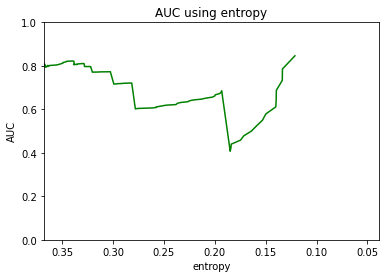

Uncertainty:  093_E108074625 , 101_E108257268 , 179_E110063911 , 197_E104404205 , 170_E109873730 , 108_E108431861 , 163_E109687083 , 080_E107724418 , 241_E111656351 , 159_E109595731 , 105_E108340479 , 084_E107845421 , 074_E107567072 , 026_E106416453 , 239_E111571087 , 118_E108723029 , 161_E109629626 , 047_E106880231 , 127_E108872750 , 008_E101982858 , 154_E109530516 , 
High confident:  ['093_E108074625', '179_E110063911', '197_E104404205', '170_E109873730', '108_E108431861', '163_E109687083', '080_E107724418', '159_E109595731', '105_E108340479', '084_E107845421', '026_E106416453', '239_E111571087', '118_E108723029', '161_E109629626', '047_E106880231', '127_E108872750', '008_E101982858', '169_E109839821', '064_E107148589', '061_E107182509', '142_E109248030', '261_E105884483', '124_E103464034', '165_E109694498', '235_E111504016', '171_E109880093', '131_E108980070', '146_E109315591', '200_E110559584', '021_E106360734', '167_E109747437', '073_E107560178', '032_E102498045', '136_E109081638'

In [19]:
# Classification using MC
# Input: brain windows and hematoma region in folder italy_ds/classification/*_brain_seg_dilation.nii.gz (2x128x128x96)
# Output: AUC
# Code: using MyDenseNet121 which is developed from DenseNet121
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
expectAUC = 0.82
variance = np.var(dropout_predictions, axis=0)  # shape (n_samples, n_classes)
std = np.std(dropout_predictions, axis=0)  # shape (n_samples, n_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
J_stats = [None]
opt_thresholds = [None]
thresholds = dict()
y1 = y.cpu().numpy().copy()
name1 = names.copy()
mean1 = mean.copy()
entropy=[]
for k in range(yval.shape[0]):    
    tmp = predictive_entropy(sigmoid(dropout_predictions[:,k]))
    entropy = np.append(entropy, tmp)
auc=[]
auc=[]
sort_values = sorted(zip(entropy, y1, mean1, name1), key=lambda x:x[0], reverse=True)
entropy, y1, mean1, name1 = zip(*sort_values)
for i in range(len(entropy)-1):    
    y1 = np.delete(y1, 0)
    mean1 = np.delete(mean1, 0)
    y_onehot = [y_trans(i) for i in decollate_batch(y1)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch((mean1))]
    auc_metric1 = monai.metrics.ROCAUCMetric()
    auc_metric1(y_pred_act, y_onehot)
    auc = np.append(auc, auc_metric1.aggregate())
    auc_metric1.reset()
auc = np.append(auc, 1)
plt.plot(entropy, auc, color='green')
plt.ylim(0, 1)
plt.xlim(np.max(entropy),np.min(entropy))
plt.xlabel('entropy')
plt.ylabel('AUC')
plt.title('AUC using entropy')
plt.show()
indexAUC = np.where(auc>expectAUC)[0][0]
threshold = entropy[indexAUC]
y1 = y.cpu().numpy().copy()
mean1 = mean.copy()
std1 = std.copy()
entropy=[]
for k in range(yval.shape[0]):    
    tmp = predictive_entropy(sigmoid(dropout_predictions[:,k]))
    entropy = np.append(entropy, tmp)
index = np.where(entropy>=threshold)[0]
print("Uncertainty: ", end =" ")
for k in range(len(index)):
  print(name1[k], "," , end =" ")
y1 = np.delete(y1, index)
mean1 = np.delete(mean1,index)
name1 = np.delete(name1, index)
print("\nHigh confident: ", end =" ")
print(list(name1))
y_onehot = [y_trans(i) for i in decollate_batch(y1)]
y_pred_act = [y_pred_trans(i) for i in decollate_batch((mean1))]
auc_metric1 = monai.metrics.ROCAUCMetric()
auc_metric1(y_pred_act, y_onehot)
print("AUC total= ")
print(auc_metric1.aggregate())
auc_metric1.reset()
